In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd gdrive/MyDrive/Colab Notebooks/workspace/

/content/gdrive/MyDrive/Colab Notebooks/workspace


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gdrive/MyDrive/Colab Notebooks/workspace/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=21919647 sha256=679703e22c33ae8bd4d50d05fcfcf20b1c84be5f757f65f0a819fac8affabefd
  Stored in directory: /tmp/pip-ephem-wheel-cache-g224afcz/wheels/55/9a/eb/372440ba04fb8db43db4ee227ac4a4f4113c68d94d40a58aa6
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=f35ded08b61549855fc46072a2ce4007995fec758e1650618f1ed7e3bff81ee7
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44009 sha256=2b6c3255856601bb0bfb3bcb4150ac13338120414beaf0b4ecb33799e7fbcaf1
  Stored in directory: /root/.cache/pip/wheels/d6/e5/b1/6b151d9b535ee50aaa6ab27d145a0104b6df02e5636f0376da
  

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


# Explore data augmentations

This notebook will be used to test different data augmentation strategies. In your config file, you can modify the augmentations by adding `data_augmentation_options`. For example, I would like to add a random RGB to gray transform with a probability of 0.2:
```
data_augmentation_options {
    random_rgb_to_gray {
    probability: 0.2
    }
```

A complete list of augmentation is provided the [`preprocessor.proto` file of the Tf Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

In [ ]:
def recenter_image(image):
    # ssd preprocessing
    image += [123.68, 116.779, 103.939]
    return image

def display_instances(image, bboxes, classes):
    image = recenter_image(image)
    w, h, _ = image.shape
    # resize the bboxes
    bboxes[:, [0, 2]] *= w
    bboxes[:, [1, 3]] *= h
    
    f, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image.astype(np.uint8))
    for bb, cl in zip(bboxes, classes):
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='r', linewidth=2)
        ax.add_patch(rec)
    plt.show()

def display_batch(batch):
    # get images, bboxes and classes
    batched_images = batch[0]['image'].numpy()
    batched_bboxes = batch[1]['groundtruth_boxes'].numpy()
    batched_classes = batch[1]['groundtruth_classes'].numpy()
    num_bboxes = batch[1]['num_groundtruth_boxes'].numpy()
    batch_size = batched_images.shape[0]
    for idx in range(batch_size):
        display_instances(batched_images[idx, ...], 
                          batched_bboxes[idx, :num_bboxes[idx], :],
                          batched_classes[idx, ...])

### Display augmentations

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip

Cloning into 'waymo-od'...
remote: Enumerating objects: 1718, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 1718 (delta 69), reused 133 (delta 67), pack-reused 1575
Receiving objects: 100% (1718/1718), 42.15 MiB | 12.57 MiB/s, done.
Resolving deltas: 100% (1088/1088), done.
Checking out files: 100% (250/250), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/om2
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
  remotes/origin/r1.2
  remotes/origin/r1.3
M	configure.sh
M	pip_pkg_scripts/build.sh
M	pip_pkg_scripts/build_pip_pkg.sh
M	pip_pkg_scripts/docker_build_all.sh
M	third_party/toolchains/preconfig/ubuntu16.04/gcc7_manylinux2010-nvcc-cuda10.0/BUILD
M	third_party/toolchains/preconfig/ubuntu16.04/gcc7_manylinux2010-nvcc-cuda10.0/cc_toolchain_config.bzl
M	third_party/toolchains/preconfig/ubuntu16.04/gcc7_manylinux2010-nvcc-cuda10.0/clang/bin/c

In [ ]:
!pip3 install waymo-open-dataset-tf-2-1-0==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 8.4 MB/s 
     |████████████████████████████████| 421.8 MB 5.5 kB/s 
     |████████████████████████████████| 26.1 MB 1.2 MB/s 
     |████████████████████████████████| 3.8 MB 47.1 MB/s 
     |████████████████████████████████| 448 kB 70.4 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 152 kB 69.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3c2a11d869e6f2cc33a070dd031e0816e7fd97cc20e8de99c7698a74ececcbe8
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.2.0
    Uninstalling cachetools-5.2.0:
      Successfully uninstalled cachetools-5.2.0
  Attempting uninstall: google-auth
    Found existin

In [ ]:
from utils import get_train_input

In [ ]:
train_dataset = get_train_input("../solution/pipeline_new.config")

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.


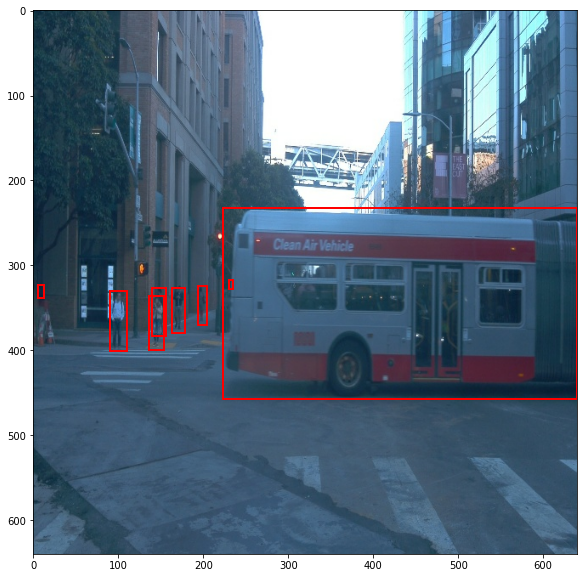

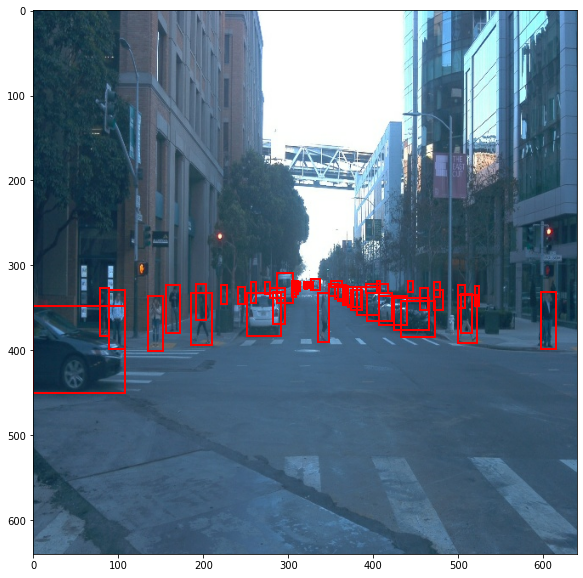

In [ ]:
%matplotlib inline

for batch in train_dataset.take(1):
    display_batch(batch)